<img src="../imgs/logo.png" width="20%" align="right" style="margin:0px 20px">


# Evolutionary Computation

## 5.2 CMA-ES

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://d9w.github.io/evolution/">https://d9w.github.io/evolution/</a>

# CMA-ES

In this section, we'll discuss the Covariance Matrix Adaptation Evolutionary Strategy, or CMA-ES [1, 2]. This is one of the most well-known evolutionary algorithms in general and is a state-of-the-art algorithm for continuous optimization. The strength of this method is that it adapts the distribution it uses to generate the next population based on the current distribution of individuals. In the previous section, we were limited to a Normal distribution with a fixed $\sigma$. The adaptive distribution of CMA-ES means it will cross search spaces faster and narrow in more exactly on optimal points.

[1] Hansen, Nikolaus, and Andreas Ostermeier. "Adapting arbitrary normal mutation distributions in evolution strategies: The covariance matrix adaptation." Proceedings of IEEE international conference on evolutionary computation. IEEE, 1996.

[2] Hansen, Nikolaus, and Andreas Ostermeier. "Completely derandomized self-adaptation in evolution strategies." Evolutionary computation 9.2 (2001): 159-195.

Let's go through a simplified version of the algorithm from [3]. There are improvements to CMA-ES beyond this basic framework, but that's beyond the scope of today. [4] provides a good review of different CMA-ES modifications.

[3] Hans-Georg Beyer (2007) Evolution strategies. Scholarpedia, 2(8):1965.

[4] Hansen, Nikolaus. "The CMA evolution strategy: a comparing review." Towards a new evolutionary computation. Springer, Berlin, Heidelberg, 2006. 75-102.

We'll start by creating a random individual $\mathbf{y}$ which will be our first expert. We also create a diagonal covariance matrix $\mathbf{C}$.

$\mbox{(L1):} \quad 
  \forall l=1, \ldots, \lambda : \;\;
  \begin{cases}
   & \mathbf{w}_l 
          \leftarrow \sigma \sqrt{ \mathbf{C} } \,
          \mathbf{N}_l(\mathbf{0}, \mathbf{1}),\\[2mm]
   & \mathbf{y}_l \leftarrow \mathbf{y}  + \mathbf{w}_l, \\[2mm]
   & F_l \leftarrow F(\mathbf{y}_l),
  \end{cases}$

In the first step, (L1), $\lambda$ offspring $\mathbf{y}_l$ are created by transforming standard normally distributed random vectors using a transformation matrix $\sqrt{\mathbf{C}}$ which is given by Cholesky decomposition of the covariance matrix $\mathbf{C}$ and the global step size factor $\sigma$. We also evaluate every individual, creating $F$.

$\mbox{(L2):} \quad 
      \mathbf{y} \leftarrow \mathbf{y} + \langle \mathbf{w} \rangle$

In (L2) the best $\mu$ mutations are recombined forming the recombinant $\mathbf{y}$ (center of mass individual) for the next generation. 

$\mbox{(L3):} \quad 
            \mathbf{s} \leftarrow \left(1-\frac{1}{\tau}\right)\mathbf{s}
          + \sqrt{\frac{\mu}{\tau} \left(2-\frac{1}{\tau}\right)} \,
            \frac{\langle \mathbf{w} \rangle}{\sigma}$

Vector $\langle \mathbf{w} \rangle$ combines individuals from two consecutive generations so $\langle \mathbf{w} \rangle/\sigma$ represents the tendency of evolution in the search space. In (L3), this information is cumulated in the $\mathbf{s}$ vector, which exponentially decays with the time constant $\tau$. A good default for this is $\tau=\sqrt{n}$.

$\mbox{(L4):} \quad 
      \mathbf{C} \leftarrow 
      \left(1-\frac{1}{\tau_{\mathrm{c}}}\right)\mathbf{C}
              + \frac{1}{\tau_{\mathrm{c}}} \mathbf{s} \mathbf{s}^T$

In (L4), the direction vector $\mathbf{s}$ is used to update the covariance matrix $\mathbf{C}$ with time constant $\tau_{\mathrm{c}} \propto n^2$

$\mbox{(L5):} \quad  
       \mathbf{s}_\sigma
       \leftarrow \left(1-\frac{1}{\tau_\sigma}\right) \mathbf{s}_\sigma
                  + \sqrt{\frac{\mu}{\tau_\sigma}
                    \left(2-\frac{1}{\tau_\sigma}\right)} \,
                      \langle \mathbf{N}(\mathbf{0}, \mathbf{1}) \rangle$

$\mbox{(L6):} \quad  
      \sigma \leftarrow \sigma\exp\left[
                        \frac{\| \mathbf{s}_{\sigma} \|^2 - n}
                                   {2 n \sqrt{n} }
                                        \right]$

The distribution standard deviation $\sigma$ is then calculated in (L5) and (L6) using the cumulated step size adaptation (CSA) technique with time constant $\tau_\sigma = \sqrt{n}$ (initially $\mathbf{s}_\sigma = \mathbf{0}$). $\langle \mathbf{N}(\mathbf{0}, \mathbf{1}) \rangle$ is the distribution we calculated in (L1). 

So instead of simply using a Normal distribution to create the next generation, CMA-ES transforms a normal distribution by the covariance matrix $\mathbf{C}$. It also moves at self-adjusting $\sigma$. This makes its movement around the search space much more effective, as it is informed by the shape of the search space given through the fitness values $F$.

Let's see an example of that.

In [2]:
using Random
using LinearAlgebra
using Statistics
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


In [3]:
solution = [3.5, -0.2]
sphere(x::Array{Float64}) = sum((x .- solution).^2)
himmelblau(x::Array{Float64}) = (x[1]^2 + x[2] - 11)^2 + (x[1] + x[2]^2 - 7)^2
styblinski_tang(x::Array{Float64}) = sum(x.^4 .- 16 .* x.^2 .+ 5 .* x) / 2.0
rastrigin(x::Array{Float64}) = 10.0 * length(x) .+ sum((x .- solution).^2 .- 10 .* cos.(2*pi.*(x .- solution)))
objective = sphere

sphere (generic function with 1 method)

As with last time, we'll optimize over 2 continuous variables. We'll set default values of the time constants based on $N$. These are recommended values for CMA-ES [5]

[5] Hansen, Nikolaus, Sibylle D. Müller, and Petros Koumoutsakos. "Reducing the time complexity of the derandomized evolution strategy with covariance matrix adaptation (CMA-ES)." Evolutionary computation 11.1 (2003): 1-18.

In [4]:
N = 2
μ = 5
λ = 10
τ = sqrt(N)
τ_c = N^2
τ_σ = sqrt(N);

Now let's make our random expert and create placeholder fitness and offspring vectors.

In [5]:
y = randn(N)
offspring = Array{Array{Float64}}(undef, λ)
F = Inf .* ones(λ);

Finally, we need to initialize $\mathbf{C}, \mathbf{N}, \mathbf{w}, \mathbf{s}, \mathbf{s_\sigma},$ and $\mathbf{\sigma}$.

In [6]:
C = Diagonal{Float64}(I, N)
W = zeros(N, λ)
s = zeros(N)
s_σ = zeros(N)
σ = 1.0
E = zeros(N, λ);

Step 1: We calculate the offspring distribution $\mathbf{w}$ then center it at the center-of-mass individual $\mathbf{y}$.

$\mbox{(L1):} \quad 
  \forall l=1, \ldots, \lambda : \;\;
  \begin{cases}
   & \mathbf{w}_l 
          \leftarrow \sigma \sqrt{ \mathbf{C} } \,
          \mathbf{N}_l(\mathbf{0}, \mathbf{1}),\\[2mm]
   & \mathbf{y}_l \leftarrow \mathbf{y}  + \mathbf{w}_l, \\[2mm]
   & F_l \leftarrow F(\mathbf{y}_l),
  \end{cases}$

In [7]:
sqrt_c = cholesky((C + C') / 2.0).U

2×2 Diagonal{Float64,Array{Float64,1}}:
 1.0   ⋅ 
  ⋅   1.0

Note that our $\mathbf{C}$ covariance matrix is currently 1, so this first distribution will just be a normal distribution without any transformation. We will then evaluate every individual.

In [8]:
for i in 1:λ
    E[:,i] = randn(N)
    W[:,i] = σ * (sqrt_c * E[:,i])
    offspring[i] = y + W[:,i]
    F[i] = objective(offspring[i])
end

Now that we have evaluated the individuals, we will select a subset of them to inform the next generation. We'll simply use a truncation selection, taking the top $\mu$ individuals.

In [9]:
idx = sortperm(F)[1:μ]

5-element Array{Int64,1}:
  8
 10
  3
  6
  2

Now step 2. We update $\mathbf{y}$ using the top $\mu$ individuals in $\mathbf{w}$

$\mbox{(L2):} \quad 
      \mathbf{y} \leftarrow \mathbf{y} + \langle \mathbf{w} \rangle$

In [10]:
w = vec(mean(W[:,idx], dims=2))
y += w

2-element Array{Float64,1}:
 1.0648244969173282
 0.5908349095580181

In step 3, we update the direction vector $\mathbf{s}$.

$\mbox{(L3):} \quad 
            \mathbf{s} \leftarrow \left(1-\frac{1}{\tau}\right)\mathbf{s}
          + \sqrt{\frac{\mu}{\tau} \left(2-\frac{1}{\tau}\right)} \,
            \frac{\langle \mathbf{w} \rangle}{\sigma}$

In [11]:
s = (1.0 - 1.0/τ)*s + (sqrt(μ/τ * (2.0 - 1.0/τ))/σ)*w

2-element Array{Float64,1}:
  1.9839220026727034
 -0.27566631318101525

Next we update our covariance matrix $\mathbf{C}$. Note that it will no longer be a diagonal matrix: our next update will use a transformed distribution to generate the population.

$\mbox{(L4):} \quad 
      \mathbf{C} \leftarrow 
      \left(1-\frac{1}{\tau_{\mathrm{c}}}\right)\mathbf{C}
              + \frac{1}{\tau_{\mathrm{c}}} \mathbf{s} \mathbf{s}^T$

In [12]:
C = (1.0 - 1.0/τ_c).*C + (s./τ_c)*s'

2×2 Array{Float64,2}:
  1.73399   -0.136725
 -0.136725   0.768998

Finally, we update the $\sigma$, which is the standard deviation of the distribution we generate in the first step. Note that its initial value was `1.0`.

$\mbox{(L5):} \quad  
       \mathbf{s}_\sigma
       \leftarrow \left(1-\frac{1}{\tau_\sigma}\right) \mathbf{s}_\sigma
                  + \sqrt{\frac{\mu}{\tau_\sigma}
                    \left(2-\frac{1}{\tau_\sigma}\right)} \,
                      \langle \mathbf{N}(\mathbf{0}, \mathbf{1}) \rangle$

$\mbox{(L6):} \quad  
      \sigma \leftarrow \sigma\exp\left[
                        \frac{\| \mathbf{s}_{\sigma} \|^2 - n}
                                   {2 n \sqrt{n} }
                                        \right]$

In [13]:
ɛ = vec(mean(E[:,idx], dims=2))
s_σ = (1.0 - 1.0/τ_σ)*s_σ + sqrt(μ/τ_σ*(2.0 - 1.0/τ_σ))*ɛ
σ = σ*exp(((s_σ'*s_σ)[1] - N)/(2*N*sqrt(N)))

1.4271277052449598

That's a lot! Let's put it all together in an object and see how it runs over multiple iterations.

In [14]:
mutable struct CMAES
    N::Int
    μ::Int
    λ::Int
    τ::Float64
    τ_c::Float64
    τ_σ::Float64
    population::Array{Array{Float64}}
    offspring::Array{Array{Float64}}
    F_μ::Array{Float64}
    F_λ::Array{Float64}
    C::Array{Float64}
    s::Array{Float64}
    s_σ::Array{Float64}
    σ::Float64
    E::Array{Float64}
    W::Array{Float64}
    x::Array{Float64}
end

In [48]:
function CMAES(;N=2, μ=20, λ=40, τ=sqrt(N), τ_c=N^2, τ_σ=sqrt(N))
    x = randn(N)
    population = fill(x, µ)
    offspring = Array{Array{Float64}}(undef, λ)
    F_µ = Inf .* ones(µ)
    F_λ = Inf .* ones(λ)
    C = Array(Diagonal{Float64}(I, N))
    s = zeros(N)
    s_σ = zeros(N)
    σ = 1.0
    E = zeros(N, λ)
    W = zeros(N, λ);
    CMAES(N, μ, λ, τ, τ_c, τ_σ, population, offspring, F_µ, F_λ, C, s, s_σ, σ, E, W, x)
end

CMAES

In [49]:
c = CMAES()

CMAES(2, 20, 40, 1.4142135623730951, 4.0, 1.4142135623730951, Array{Float64,N} where N[[-1.4402032659002617, 0.5636064524417057], [-1.4402032659002617, 0.5636064524417057], [-1.4402032659002617, 0.5636064524417057], [-1.4402032659002617, 0.5636064524417057], [-1.4402032659002617, 0.5636064524417057], [-1.4402032659002617, 0.5636064524417057], [-1.4402032659002617, 0.5636064524417057], [-1.4402032659002617, 0.5636064524417057], [-1.4402032659002617, 0.5636064524417057], [-1.4402032659002617, 0.5636064524417057], [-1.4402032659002617, 0.5636064524417057], [-1.4402032659002617, 0.5636064524417057], [-1.4402032659002617, 0.5636064524417057], [-1.4402032659002617, 0.5636064524417057], [-1.4402032659002617, 0.5636064524417057], [-1.4402032659002617, 0.5636064524417057], [-1.4402032659002617, 0.5636064524417057], [-1.4402032659002617, 0.5636064524417057], [-1.4402032659002617, 0.5636064524417057], [-1.4402032659002617, 0.5636064524417057]], Array{Float64,N} where N[#undef, #undef, #undef, #un

In [50]:
function step!(c::CMAES; obj=objective, visualize=false, anim=Nothing)
    # L1
    sqrt_c = cholesky((c.C + c.C') / 2.0).U
    for i in 1:c.λ
        c.E[:,i] = randn(c.N)
        c.W[:,i] = c.σ * (sqrt_c * c.E[:,i])
        c.offspring[i] = c.x + c.W[:,i]
        c.F_λ[i] = obj(c.offspring[i])
    end    
    # Select new parent population
    idx = sortperm(c.F_λ)[1:c.μ]
    for i in 1:c.μ
        c.population[i] = c.offspring[idx[i]]
        c.F_μ[i] = c.F_λ[idx[i]]
    end    
    # L2
    w = vec(mean(c.W[:,idx], dims=2))
    c.x += w    
    # L3
    c.s = (1.0 - 1.0/c.τ)*c.s + (sqrt(c.μ/c.τ * (2.0 - 1.0/c.τ))/c.σ)*w   
    # L4
    c.C = (1.0 - 1.0/c.τ_c).*c.C + (c.s./c.τ_c)*c.s'    
    # L5
    ɛ = vec(mean(c.E[:,idx], dims=2))
    c.s_σ = (1.0 - 1.0/c.τ_σ)*c.s_σ + sqrt(c.μ/c.τ_σ*(2.0 - 1.0/c.τ_σ))*ɛ    
    # L6
    c.σ = c.σ*exp(((c.s_σ'*c.s_σ)[1] - c.N)/(2*c.N*sqrt(c.N)))
    if visualize
        #plot(xs, ys, fz, st=:contour)
        scatter!([c.offspring[i][1] for i in 1:λ], [c.offspring[i][2] for i in 1:λ], 
            xlims=(-5, 5), ylims=(-5, 5), legend=:none)
        scatter!([c.x[1]], [c.x[2]], color=:black, marker=:rect,
            xlims=(-5, 5), ylims=(-5, 5), legend=:none)
        frame(anim)
    end
    c
end

step! (generic function with 1 method)

In [51]:
function plot_obj()
    c = CMAES()
    println("x initial: ", c.x)
    anim = Animation()
    i_print = 0
    for i in 1:100
        v = mod(i, 1) == 0
        step!(c, visualize=v, anim=anim)
    end
    println("x final: ", c.x)
    gif(anim)
end

plot_obj (generic function with 1 method)

[3.5, -0.2]
x initial: [1.0573783084082349, -0.2077318534789003]
x final: [3.5000003736001033, -0.2000002462444343]


┌ Info: Saved animation to 
│   fn = /home/guillaume/Documents/evolution/5_strategies/tmp.gif
└ @ Plots /home/guillaume/.julia/packages/Plots/uCh2y/src/animation.jl:104


Plots.AnimatedGif("/home/guillaume/Documents/evolution/5_strategies/tmp.gif")
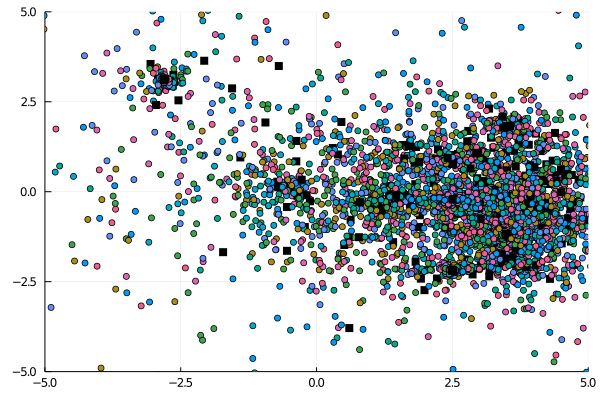

In [53]:
xs = -5.0:0.1:5.0
ys = -5.0:0.1:5.0

objective = rastrigin # sphere, himmelblau, styblinski_tang, rastrigin
fz(x, y) = objective([x, y])
println(solution) # optimal for sphere and rastrigin
plot_obj()

<div class="alert alert-success">
    <b>Exercise</b>
    <br/>
    Modify the parent population size and child population of the problem. Can you get CMA-ES to reliably converge on the Rastrigin function? What about for higer dimensions of $n$? Report your $\mu$ and $\lambda$ values in the class chat.
</div>    